In [58]:
from __future__ import division, print_function, absolute_import

from tmm import (coh_tmm, color, unpolarized_RT, ellips,
                       position_resolved, find_in_structure_with_inf)

import numpy as np
from numpy import pi, linspace, inf, array, arange
import pandas as pd  
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import math

%matplotlib inline

degree = pi/180

In [62]:
def position_resolved2(layer, distance, coh_tmm_data):
    """
    Starting with output of coh_tmm(), calculate the Poynting vector,
    absorbed energy density, and E-field at a specific location. The
    location is defined by (layer, distance), defined the same way as in
    find_in_structure_with_inf(...).

    Returns a dictionary containing:

    * poyn - the component of Poynting vector normal to the interfaces
    * absor - the absorbed energy density at that point
    * Ex and Ey and Ez - the electric field amplitudes, where
      z is normal to the interfaces and the light rays are in the x,z plane.

    The E-field is in units where the incoming |E|=1; see
    https://arxiv.org/pdf/1603.02720.pdf for formulas.
    """
    if layer > 0:
        v,w = coh_tmm_data['vw_list'][layer]
    else:
        v = 1
        w = coh_tmm_data['r']
    kz = coh_tmm_data['kz_list'][layer]
    th = coh_tmm_data['th_list'][layer]
    n = coh_tmm_data['n_list'][layer]
    n_0 = coh_tmm_data['n_list'][0]
    th_0 = coh_tmm_data['th_0']
    pol = coh_tmm_data['pol']

    #assert ((layer >= 1 and 0 <= distance <= coh_tmm_data['d_list'][layer])
     #           or (layer == 0 and distance <= 0))

    # Amplitude of forward-moving wave is Ef, backwards is Eb
    Ef = v * np.exp(1j * kz * distance)
    Eb = w * np.exp(-1j * kz * distance)

    # Poynting vector
    if pol == 's':
        poyn = ((n*np.cos(th)*np.conj(Ef+Eb)*(Ef-Eb)).real) / (n_0*np.cos(th_0)).real
    elif pol == 'p':
        poyn = (((n*np.conj(np.cos(th))*(Ef+Eb)*np.conj(Ef-Eb)).real)
                    / (n_0*np.conj(np.cos(th_0))).real)

    # Absorbed energy density
    if pol == 's':
        absor = (n*np.cos(th)*kz*np.abs(Ef+Eb)**2).imag / (n_0*np.cos(th_0)).real
    elif pol == 'p':
        absor = (n*np.conj(np.cos(th))*
                 (kz*np.abs(Ef-Eb)**2-np.conj(kz)*np.abs(Ef+Eb)**2)
                ).imag / (n_0*np.conj(np.cos(th_0))).real

    # Electric field
    if pol == 's':
        Ex = 0
        Ey = Ef + Eb
        Ez = 0
    elif pol == 'p':
        Ex = (Ef - Eb) * np.cos(th)
        Ey = 0
        Ez = (-Ef - Eb) * np.sin(th)

    return {'poyn': poyn, 'absor': absor, 'Ex': Ex, 'Ey': Ey, 'Ez': Ez}

In [25]:
Ag  = pd.read_table("C:\\Users\AdminTechnik\\Documents\\Python\\Ag.txt")
#set values for the wavelengths,n,k of Ag
n_Ag=Ag.iloc[:,1]
wl_Ag = Ag.iloc[:,0]
k_Ag=Ag.iloc[:,2]

#create array for silver 
#first set an empty complex array 
material_nk_data = np.zeros((len(wl_Ag),2),dtype=complex)

for i in range(len(wl_Ag)):
    material_nk_data[i,0] = complex(wl_Ag.iloc[i],0)
    material_nk_data[i,1] = complex(n_Ag.iloc[i],k_Ag.iloc[i])

In [26]:
Si  = pd.read_table("C:\\Users\AdminTechnik\\Documents\\Python\\Si.txt")
#set values for the wavelengths,n,k of Si
n_Si=Si.iloc[:,1]
wl_Si = Si.iloc[:,0]
k_Si=Si.iloc[:,2]

#create array for si
#first set an empty complex array 
material_nk_data_Si = np.zeros((len(wl_Si),2),dtype=complex)

for i in range(len(wl_Si)):
    material_nk_data_Si[i,0] = complex(wl_Si.iloc[i],0)
    material_nk_data_Si[i,1] = complex(n_Si.iloc[i],k_Si.iloc[i])

In [27]:
Gr  = pd.read_table("C:\\Users\AdminTechnik\\Documents\\Python\\Gr.txt", encoding="utf8")
#encoded from a .csv --> .txt MS DOS 
#set values for the wavelengths,n,k of graphene
n_Gr=Gr.iloc[:,1]
wl_Gr = Gr.iloc[:,0]
k_Gr=Gr.iloc[:,2]

#create array for graphene 
#first set an empty complex array 
material_nk_data_Gr = np.zeros((len(wl_Gr),2),dtype=complex)

for i in range(len(wl_Gr)):
    material_nk_data_Gr[i,0] = complex(wl_Gr.iloc[i],0)
    material_nk_data_Gr[i,1] = complex(n_Gr.iloc[i],k_Gr.iloc[i])

In [28]:
SiO2  = pd.read_table("C:\\Users\AdminTechnik\\Documents\\Python\\SiO2.txt")
#set values for the wavelengths,n,k of SiO2
n_SiO2=SiO2.iloc[:,1]
wl_SiO2 = SiO2.iloc[:,0]
k_SiO2=SiO2.iloc[:,2]

#create array for sio2 
#first set an empty complex array 
material_nk_data_SiO2 = np.zeros((len(wl_SiO2),2),dtype=complex)

for i in range(len(wl_SiO2)):
    material_nk_data_SiO2[i,0] = complex(wl_SiO2.iloc[i],0)
    material_nk_data_SiO2[i,1] = complex(n_SiO2.iloc[i],k_SiO2.iloc[i])
    


In [29]:
Al2O3  = pd.read_table("C:\\Users\AdminTechnik\\Documents\\Python\\Al2O3_filmetrix.txt", encoding="utf8")
#set values for the wavelengths,n,k of Al2O3
n_Al2O3=Al2O3.iloc[:,1]
wl_Al2O3 = Al2O3.iloc[:,0]
k_Al2O3=Al2O3.iloc[:,2]

#create array for Al2O3 
#first set an empty complex array 
material_nk_data_Al2O3 = np.zeros((len(wl_Al2O3),2),dtype=complex)

for i in range(len(wl_Al2O3)):
    material_nk_data_Al2O3[i,0] = complex(wl_Al2O3.iloc[i],0)
    material_nk_data_Al2O3[i,1] = complex(n_Al2O3.iloc[i],k_Al2O3.iloc[i])

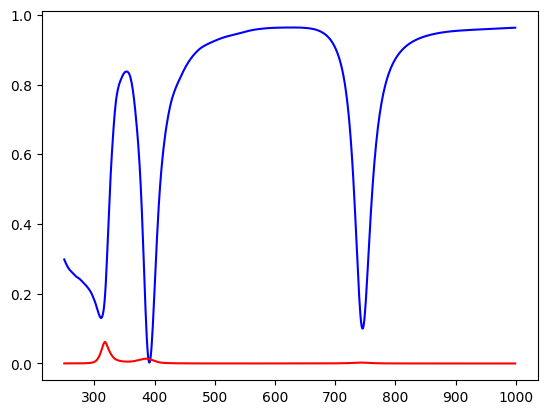

In [30]:

material_nk_fn = interp1d(material_nk_data[:,0].real,
    material_nk_data[:,1], kind='quadratic')

material_nk_fn_Si = interp1d(material_nk_data_Si[:,0].real,
    material_nk_data_Si[:,1], kind='quadratic')

material_nk_fn_SiO2 = interp1d(material_nk_data_SiO2[:,0].real,
    material_nk_data_SiO2[:,1], kind='quadratic')

material_nk_fn_Al2O3 = interp1d(material_nk_data_Al2O3[:,0].real,
    material_nk_data_Al2O3[:,1], kind='quadratic')

material_nk_fn_Gr = interp1d(material_nk_data_Gr[:,0].real,
    material_nk_data_Gr[:,1], kind='quadratic')

#d_list = [inf,30,80,40,40,100,90,inf]
air_n_fn = lambda wavelength : 1

#n_fn_list = [air_n_fn, material_nk_fn,material_nk_fn_Al2O3, material_nk_fn_Al2O3, material_nk_fn_Al2O3, material_nk_fn, material_nk_fn_SiO2,material_nk_fn_Si]
d_list = [inf,
          30,
          80,
          0.34,
          40,
          0.34,
          40,
          100,
          90,
          inf]

n_fn_list = [air_n_fn, 
            material_nk_fn,
            material_nk_fn_Al2O3,
            material_nk_fn_Gr, 
            material_nk_fn_Al2O3,
            material_nk_fn_Gr, 
            material_nk_fn_Al2O3, 
            material_nk_fn, 
            material_nk_fn_SiO2,
            air_n_fn]

R=[] 
T=[]
coh_tmm_data=[]

#todo. CHECK THE MAX RANGE OF WAVELENGHTS now it is important to give a range inside all the files wavlenghts range


lambda_vac_list = arange(250,1000)
num_layers = len(n_fn_list)
#Incidence angle
th_0=0
for lam_vac in lambda_vac_list:
    # For normal incidence, s and p polarizations are identical.
    n_list = [n_fn_list[i](lam_vac) for i in range(num_layers)]
    R.append(coh_tmm('s',n_list, d_list, th_0, lam_vac)['R'])
    T.append(coh_tmm('s',n_list, d_list, th_0, lam_vac)['T'])
    
    #coh_tmm calculates data for every wl
    coh_tmm_data.append(coh_tmm('p',n_list,d_list,th_0,lam_vac))
    
             
plt.figure()
plt.plot(lambda_vac_list,R,'blue')
plt.plot(lambda_vac_list,T,'red')

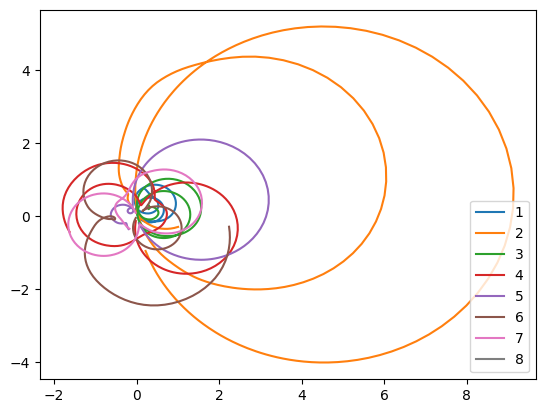

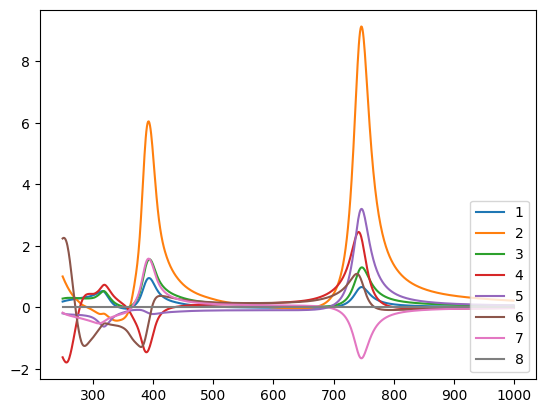

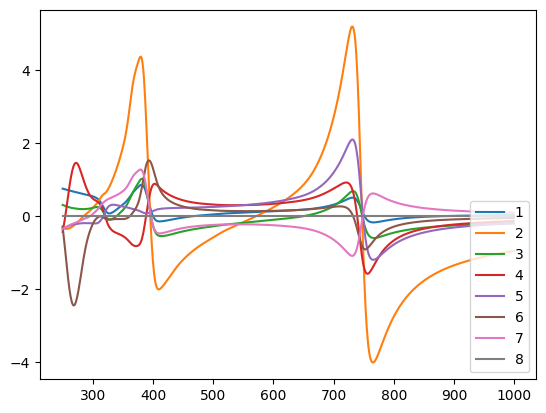

In [57]:
E=np.zeros((len(coh_tmm_data),(len(d_list)-2)), dtype=complex)
#E=np.zeros((8,750),dtype=complex)

thick=[]
thick = d_list[1:len(d_list)-1]
for d in range(len(thick)-1):

    for lam_vac_2 in range(len(coh_tmm_data)):
    
        E[lam_vac_2][d]= position_resolved2(d,thick[d],coh_tmm_data[lam_vac_2])['Ex']
        


plt.figure()

plt.plot(E.real,E.imag)
plt.legend(range(1,len(d_list)),loc="lower right") 

plt.figure()
plt.plot(lambda_vac_list,E)
plt.legend(range(1,len(d_list)),loc="lower right")

plt.figure()
plt.plot(lambda_vac_list,E.imag)
plt.legend(range(1,len(d_list)),loc="lower right")

In [44]:
E.real

array([[ 0.18663487,  1.00338058,  0.28289533, ...,  2.23892962,
        -0.17514665,  0.        ],
       [ 0.19245112,  0.95689105,  0.28747277, ...,  2.25436369,
        -0.18661828,  0.        ],
       [ 0.19803663,  0.91115906,  0.29147567, ...,  2.25939223,
        -0.19732368,  0.        ],
       ...,
       [ 0.01509211,  0.2167024 ,  0.05672706, ..., -0.02323119,
        -0.02580344,  0.        ],
       [ 0.01503804,  0.21568665,  0.05653542, ..., -0.02312146,
        -0.02565481,  0.        ],
       [ 0.01498452,  0.21468044,  0.0563453 , ..., -0.02301266,
        -0.02550777,  0.        ]])

In [33]:
for layer in range(len(d_list))
    kz = coh_tmm_data[2]['kz_list']
    Ef.append(math.exp(1j * kz * 20))

SyntaxError: invalid syntax (2484352132.py, line 1)

In [ ]:
coh_tmm_data[10]['kz_list']

array([0.0241661 +0.j        , 0.03693591+0.06704503j,
       0.0241661 +0.j        ])

In [ ]:
This error generally occurs whenever we try to access the list using indexes but give strings instead of integers or slices 
in place of either the start point, end point, or step value. The most co
mmon solution to this problem is explicitly typecasting the index to an integer. 

AssertionError: 